# Setup lib

In [1]:
# Common imports
# Importing required libraries
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
#import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from statsmodels.tsa.seasonal import seasonal_decompose
import os 
from sklearn.metrics import mean_absolute_error
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    try:
        plt.savefig(path, format=fig_extension, dpi=resolution)
    except:
        plt.savefig(fig_id + "." + fig_extension, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
pd.options.display.max_columns = None


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Preparation for Modeling

In [2]:
listings = pd.read_csv('/content/drive/MyDrive/airbnb/listings_processed.csv')

In [3]:
listings.shape

(56708, 43)

In [4]:
listings.columns

Index(['host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_listings_count', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'host_days_active',
       'balcony', 'bed_linen', 'tv', 'coffee_machine', 'cooking_basics',
       'white_goods', 'child_friendly', 'parking', 'host_greeting', 'internet',
       'long_term_stays', 'private_entrance', 'time_since_first_review',
       'time_since_last_review'],
      dtype='object')

In [5]:
listings = listings.drop(list(listings.columns[listings.columns.str.startswith('neighbourhood')]), axis=1)

In [6]:
transformed_df= pd.get_dummies(listings)

In [7]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


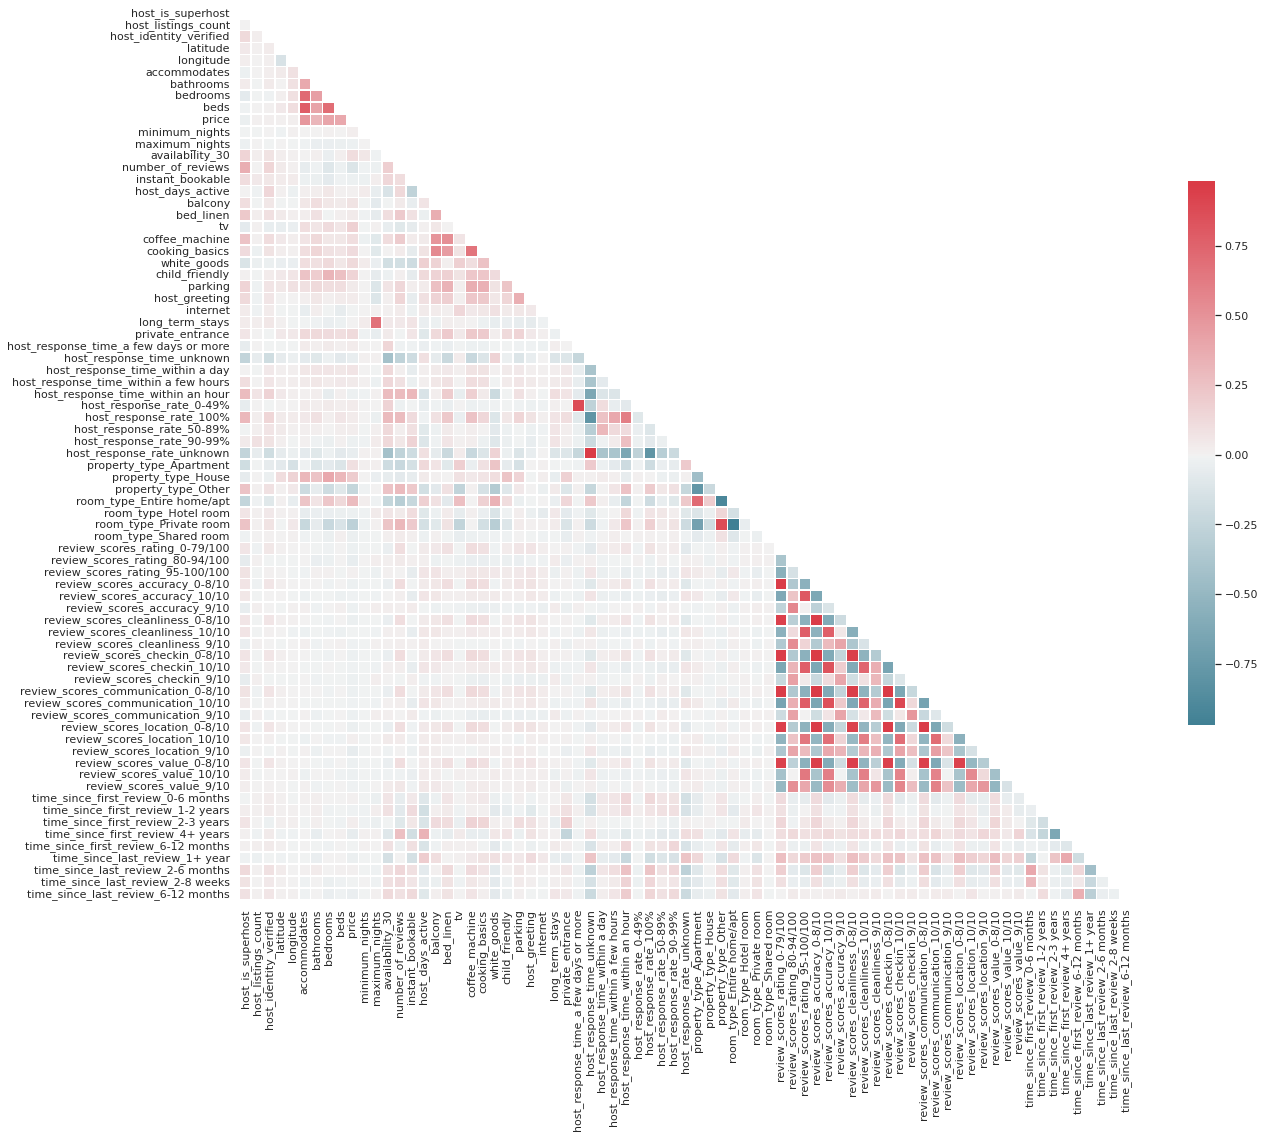

In [8]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

## Drop features

In [9]:
# Dropping collinear features
to_drop = ['latitude',
           'longitude']

to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('unknown')]))
transformed_df.drop(to_drop, axis=1, inplace=True)

## Power Transform

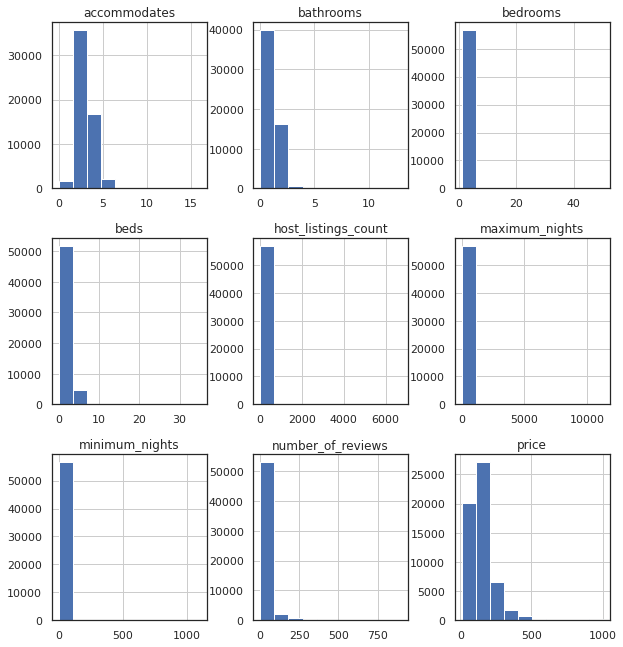

In [10]:
numerical_columns = ['accommodates', 'bathrooms', 
                     'bedrooms','beds',
                     'host_listings_count',
                     'maximum_nights', 'minimum_nights',                  
                     'number_of_reviews', 'price']

transformed_df[numerical_columns].hist(figsize=(10,11));

In [11]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64')

transformed_df[numerical_columns] = pt.fit_transform(transformed_df[numerical_columns])

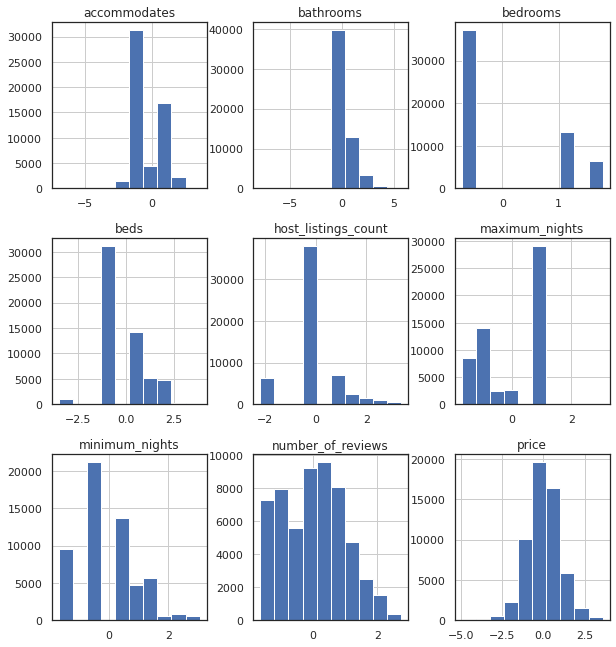

In [12]:
transformed_df[numerical_columns].hist(figsize=(10,11));

## Standarization Data

In [13]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [14]:
print(X.shape)
print(y.shape)

(56708, 70)
(56708,)


In [15]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
print(X_train.shape)
print(y_train.shape)
print(y_test.shape)
print(X_test.shape)

(39695, 70)
(39695,)
(17013,)
(17013, 70)


# Model Selection & Training

## XGBoost

In [17]:
from sklearn.metrics import accuracy_score
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Testing MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Testing r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

[12:40:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Time taken to run: 0.2 minutes

Training MSE: 0.4901
Testing MSE: 0.5183

Training r2: 0.5082
Testing r2: 0.4858


In [18]:
xgb_scores = (-cross_val_score(xgb_reg, X_train, y_train,cv=10, scoring='neg_mean_absolute_error'))
xgb_scores.mean()

[12:40:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:40:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:40:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:40:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:40:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:40:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:41:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:41:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

0.5320552554542428

## SVM Regressor

In [19]:
from sklearn.svm import LinearSVR

svr_reg_start = time.time()
svr = LinearSVR(max_iter=10000)

svr.fit(X_train, y_train)
#predicting on the train set
y_pred_train = svr.predict(X_train)
y_pred_test = svr.predict(X_test)

svr_reg_end = time.time()

print(f"Time taken to run: {round((svr_reg_end - svr_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, y_pred_train),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_pred_test),4))
print("\nTraining r2:", round(r2_score(y_train, y_pred_train),4))
print("Validation r2:", round(r2_score(y_test, y_pred_test),4))

Time taken to run: 0.7 minutes

Training MSE: 0.5437
Validation MSE: 0.5645

Training r2: 0.4544
Validation r2: 0.4399


In [20]:
svr_scores = (-cross_val_score(svr, X_train, y_train,cv=10, scoring='neg_mean_absolute_error'))
svr_scores.mean()

0.5529942563313297

## Gradient Boosting Regressor

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

#instantiate
gbrt_reg_start = time.time()

gbrt = GradientBoostingRegressor()

gbrt.fit(X_train, y_train)

# train set
y_pred_train = gbrt.predict(X_train)
y_pred_test = gbrt.predict(X_test)

gbrt_reg_end = time.time()

print(f"Time taken to run: {round((gbrt_reg_end - gbrt_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, y_pred_train),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_pred_test),4))
print("\nTraining r2:", round(r2_score(y_train, y_pred_train),4))
print("Validation r2:", round(r2_score(y_test, y_pred_test),4))

Time taken to run: 0.2 minutes

Training MSE: 0.4892
Validation MSE: 0.5185

Training r2: 0.5091
Validation r2: 0.4856


In [22]:
gbrt_scores = (-cross_val_score(gbrt, X_train, y_train,cv=10, scoring='neg_mean_absolute_error'))
gbrt_scores.mean()

0.5315661507944387

## Random Forest Regressor

In [23]:
from sklearn.ensemble import RandomForestRegressor 

# Istantiate

forest_reg_start = time.time()
forest_reg = RandomForestRegressor(n_jobs=-1) 
# Fit
forest_reg.fit(X_train, y_train)
# predict on the train set
y_pred_train = forest_reg.predict(X_train)
y_pred_test = forest_reg.predict(X_test)

forest_reg_end = time.time()

print(f"Time taken to run: {round((forest_reg_end - forest_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, y_pred_train),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_pred_test),4))
print("\nTraining r2:", round(r2_score(y_train, y_pred_train),4))
print("Validation r2:", round(r2_score(y_test, y_pred_test),4))

Time taken to run: 0.7 minutes

Training MSE: 0.0334
Validation MSE: 0.2352

Training r2: 0.9665
Validation r2: 0.7666


In [24]:
forest_reg_scores = (-cross_val_score(forest_reg, X_train, y_train,cv=10, scoring='neg_mean_absolute_error'))
forest_reg_scores.mean()

0.3370835817060845

## Hyper-Tuned Random Forest

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
# Parameters
n_estimators = randint(60, 105)
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Istantiate
forest_rig_model = RandomForestRegressor()
# making a dictionary with a list of values of possible parameters
param_dist = dict(n_estimators=n_estimators, max_features=max_features, 
                  max_depth=max_depth, min_samples_split=min_samples_split,
                  min_samples_leaf=min_samples_leaf,
                  bootstrap=bootstrap)
# n_iter controls the number of searches 

rand = RandomizedSearchCV(forest_rig_model, # our model that we used 
                          param_dist, # dictionary containing the list possible paramaters
                          cv=4, # number of cross validation folds 
                          scoring='neg_mean_absolute_error', 
                          n_iter=10, # Number of itterations
                          random_state=42, 
                          verbose=10, 
                          n_jobs=-1) # use all the available cores
# fit the model
rand.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa195aa69d0>},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=10)

In [26]:
print(-rand.best_score_) # Gives the score that we specified in the model
print(rand.best_params_) # gives the best possible combination of parameters that we passed in the dictionary
print(rand.best_estimator_) # It contains best values values of all the parameters

0.40759457943678884
{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 101}
RandomForestRegressor(min_samples_split=10, n_estimators=101)


In [27]:
# Istantiate 
forest_start = time.time()

forest = rand.best_estimator_
# fit
forest.fit(X_train, y_train)
# predict on X_train
y_pred_train = forest.predict(X_train)
y_pred_test = forest.predict(X_test)

forest_end = time.time()

print(f"Time taken to run: {round((forest_end - forest_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, y_pred_train),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_pred_test),4))
print("\nTraining r2:", round(r2_score(y_train, y_pred_train),4))
print("Validation r2:", round(r2_score(y_test, y_pred_test),4))

Time taken to run: 0.7 minutes

Training MSE: 0.0924
Validation MSE: 0.2797

Training r2: 0.9073
Validation r2: 0.7225


In [28]:
# STill high Variance 
forest_scores = (-cross_val_score(
                        forest, 
                        X_train, y_train,
                        cv=10, scoring='neg_mean_absolute_error'))
forest_scores.mean()

0.3836748570249745

# Final Pick

## Mean Square Error

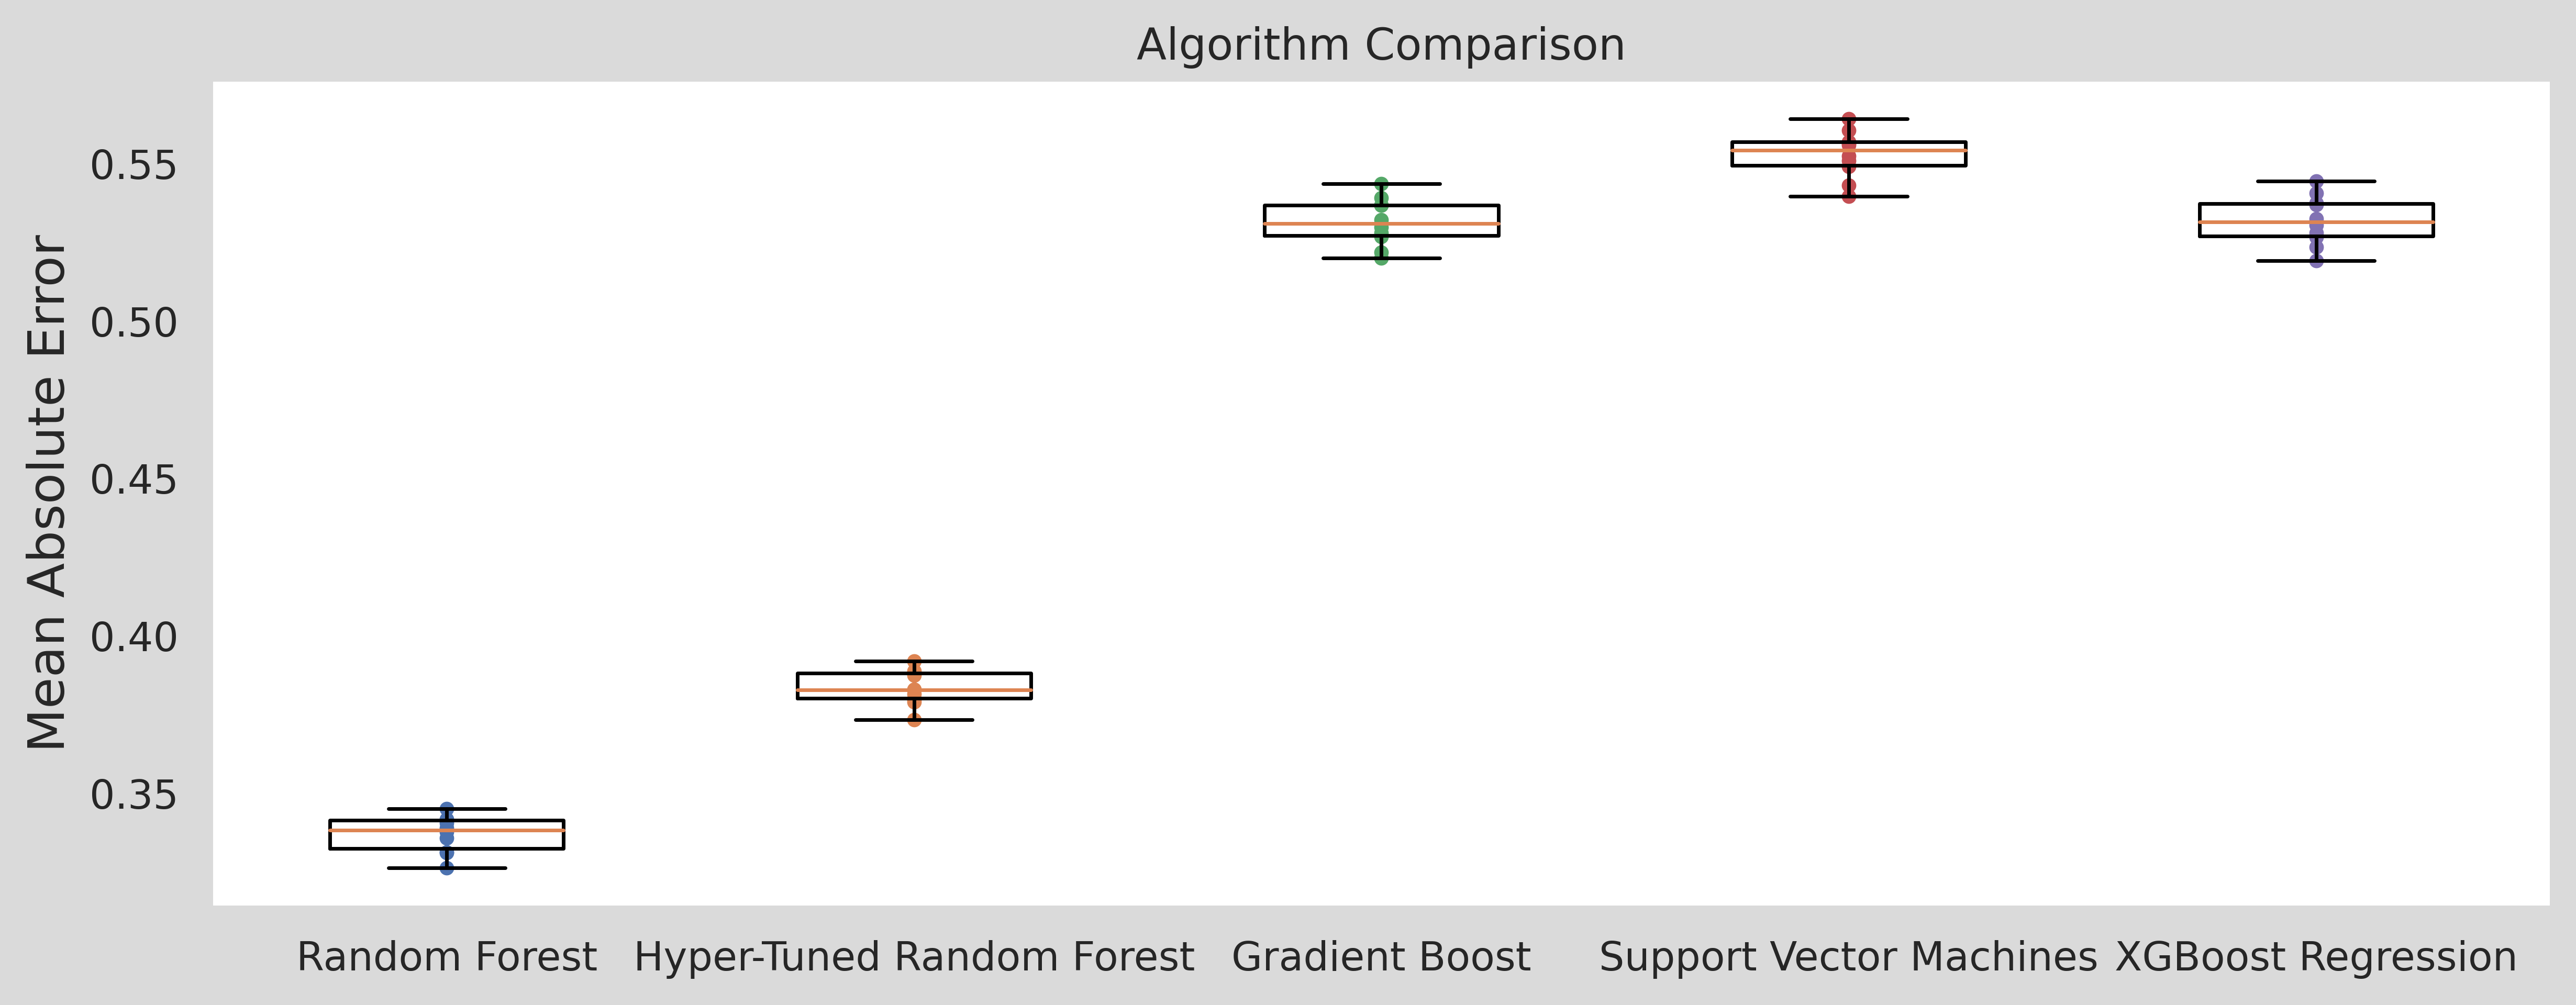

In [29]:
fig = plt.figure(figsize=(10, 4), facecolor= '#dadada', dpi=500)

plt.plot([1]*10, forest_reg_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.plot([3]*10, gbrt_scores, ".")
plt.plot([4]*10, svr_scores, ".")
plt.plot([5]*10, xgb_scores, ".")

plt.boxplot([forest_reg_scores, forest_scores, gbrt_scores, svr_scores,xgb_scores], 
            labels=("Random Forest","Hyper-Tuned Random Forest", 'Gradient Boost', 'Support Vector Machines','XGBoost Regression'))

plt.ylabel("Mean Absolute Error", fontsize=14)
plt.title('Algorithm Comparison')


# Remove the splines 
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.tight_layout() # Makes it better looking specially on laptops

# to save the fig
#fig.savefig('algcomparison.png',bbox_inches='tight', dpi=500, facecolor = '#dadada')

plt.show()

## R2 Score

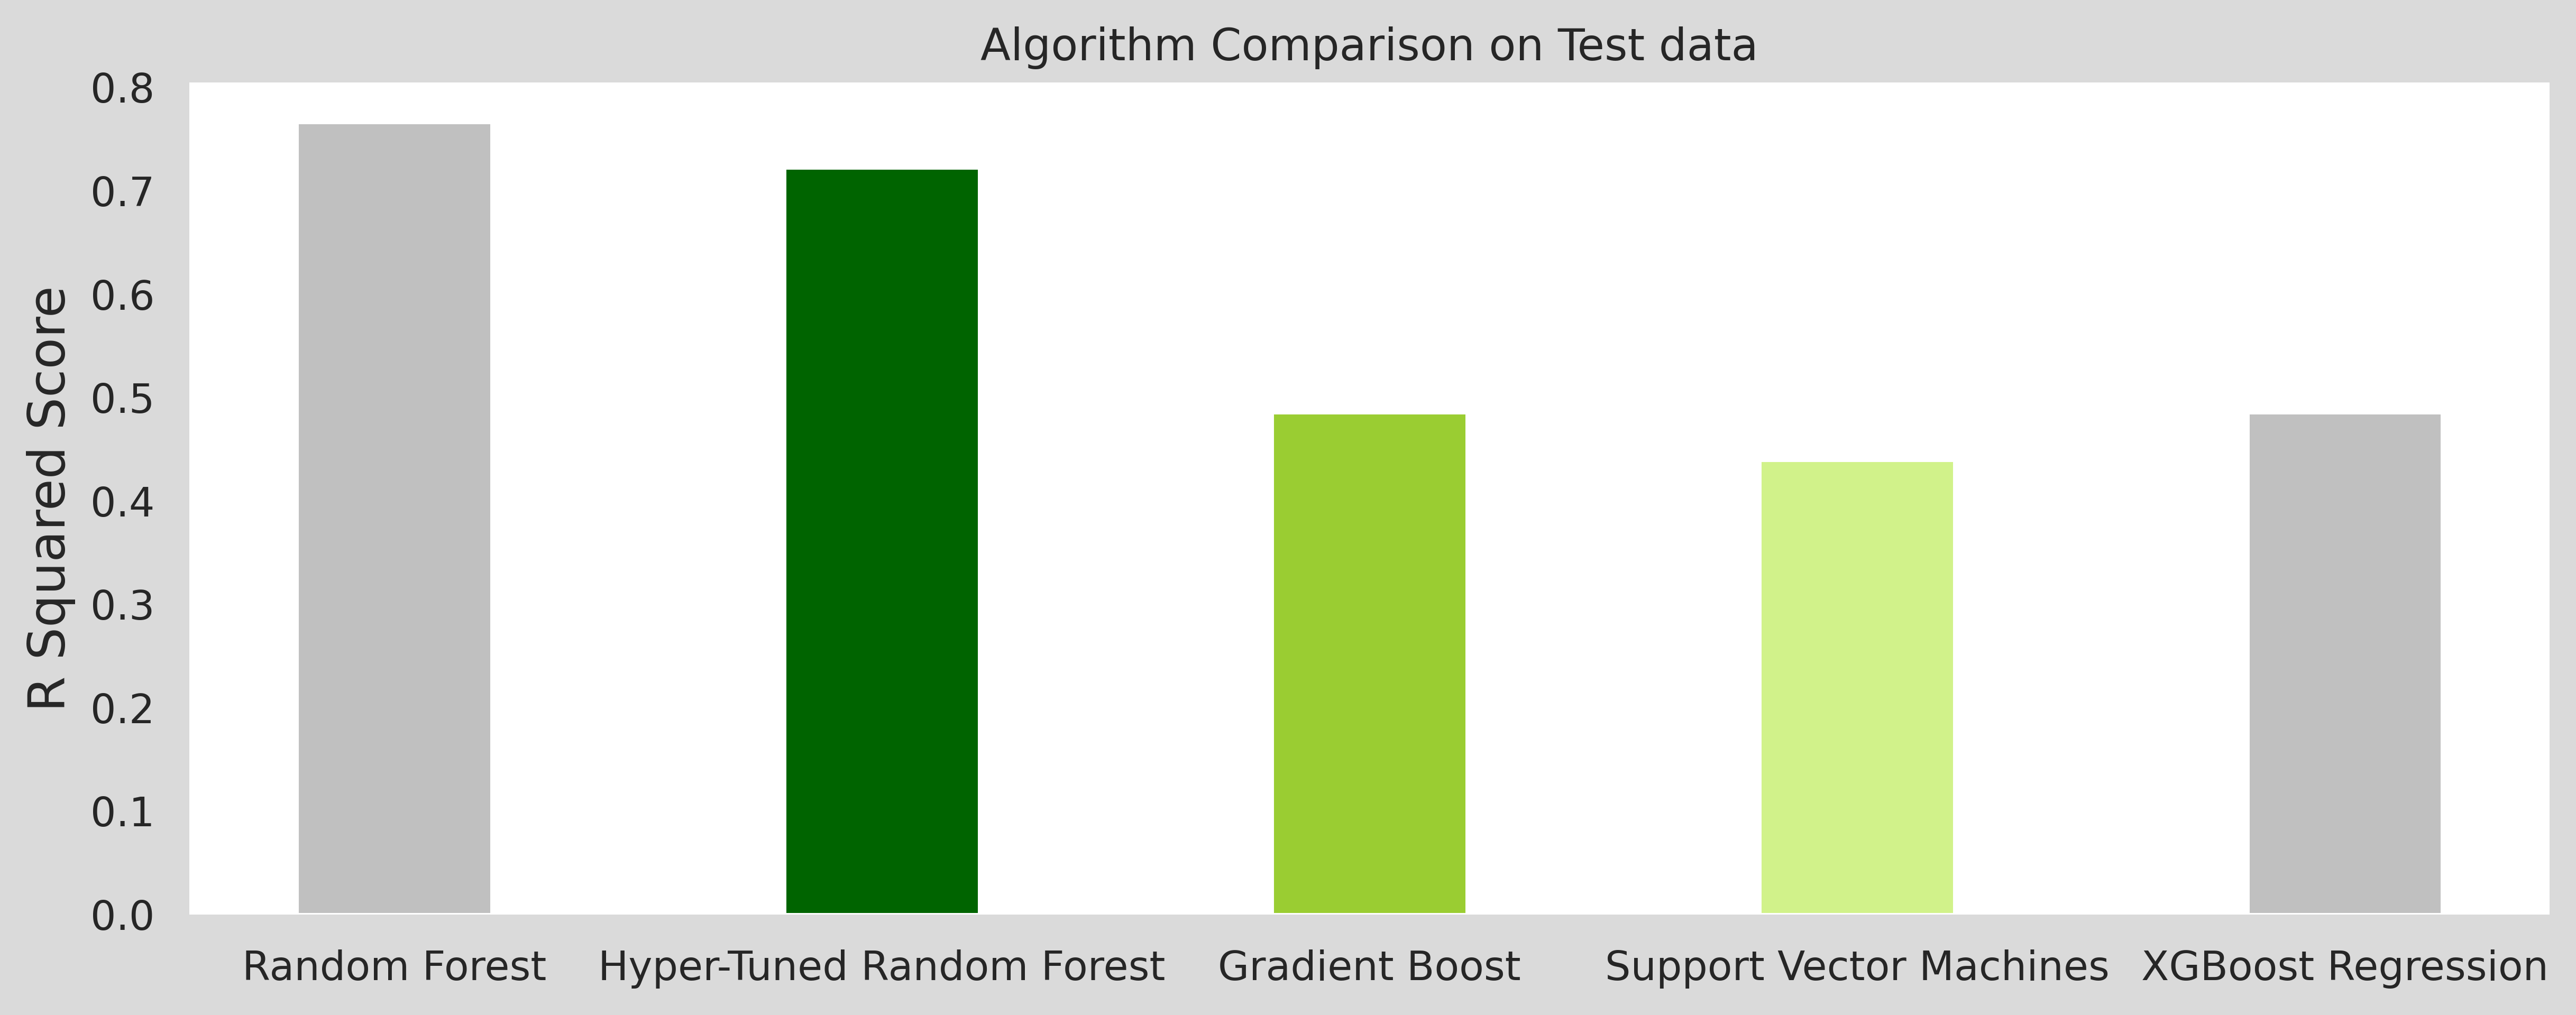

In [30]:
forest_reg_r2_score = r2_score(y_test, forest_reg.predict(X_test))
forest_r2_score = r2_score(y_test, forest.predict(X_test))
gbrt_r2_score = r2_score(y_test, gbrt.predict(X_test))
svr_r2_score = r2_score(y_test, svr.predict(X_test))
xgb_r2_score = r2_score(y_test, xgb_reg.predict(X_test))


fig = plt.figure(figsize=(10, 4), facecolor= '#dadada', dpi=500)

data = {'Random Forest': forest_reg_r2_score,
        'Hyper-Tuned Random Forest':forest_r2_score, 
        'Gradient Boost':gbrt_r2_score, 
        'Support Vector Machines':svr_r2_score,
        'XGBoost Regression':xgb_r2_score}

courses = list(data.keys())
values = list(data.values())

plt.bar(courses, values,color=['silver', 'darkgreen', 'yellowgreen', '#d1f28a' ], width = 0.4)

plt.ylabel("R Squared Score", fontsize=14)
plt.title('Algorithm Comparison on Test data')


# Remove the splines 
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.tight_layout() # Makes it better looking specially on laptops

# to save the fig
#fig.savefig('algcomparison.png',bbox_inches='tight', dpi=500, facecolor = '#dadada')

plt.show()

In [31]:
import joblib
# save the model to disk
filename = 'finalized_model.pkl'
joblib.dump(forest_reg, filename)

['finalized_model.pkl']

# Explainable Model (XAI)

In [32]:
!pip install -qqq shap

In [55]:
import shap

explainer = shap.TreeExplainer(forest_reg)

shap_values = explainer.shap_values(X_test.iloc[1])
features = X_test.columns

In [57]:
shap_values

-0.004062047084435956

In [63]:
shap.initjs()

shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=features
)

In [62]:
shap.plots.scatter(shap_values, color=shap_values)

AssertionError: ignored

## *Question: Search factors affecting the rise in prices*

In [36]:
forest_reg.feature_importances_

array([0.00550928, 0.03154157, 0.01036854, 0.26836118, 0.03694394,
       0.02210032, 0.01924888, 0.04285212, 0.03991691, 0.03874405,
       0.06404053, 0.00930037, 0.10962122, 0.00645324, 0.00769157,
       0.01190704, 0.0106834 , 0.00628952, 0.00992601, 0.00393627,
       0.0106453 , 0.00843829, 0.00431687, 0.00311966, 0.00979058,
       0.00164036, 0.00275122, 0.00279528, 0.0041233 , 0.00182077,
       0.0043253 , 0.0026887 , 0.00132587, 0.00408639, 0.00377034,
       0.00310996, 0.10405389, 0.00235651, 0.00764754, 0.00031983,
       0.00100362, 0.00255458, 0.00132266, 0.0009613 , 0.00108416,
       0.00175964, 0.0015111 , 0.00157644, 0.00194084, 0.0009731 ,
       0.00118223, 0.00166226, 0.00090531, 0.00104251, 0.00138411,
       0.00134924, 0.00232334, 0.00393281, 0.00133489, 0.00210124,
       0.00181955, 0.00098013, 0.00400688, 0.00598072, 0.00585254,
       0.00098361, 0.00344965, 0.00157967, 0.00054002, 0.00433992])

In [37]:
ft_weights_forest_reg = pd.DataFrame(forest_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_forest_reg.sort_values('weight', inplace=True)
ft_weights_forest_reg

,weight
room_type_Shared room,0.000320
time_since_last_review_2-8 weeks,0.000540
review_scores_communication_0-8/10,0.000905
review_scores_accuracy_0-8/10,0.000961
review_scores_checkin_0-8/10,0.000973
...,...
minimum_nights,0.042852
number_of_reviews,0.064041
room_type_Entire home/apt,0.104054
host_days_active,0.109621


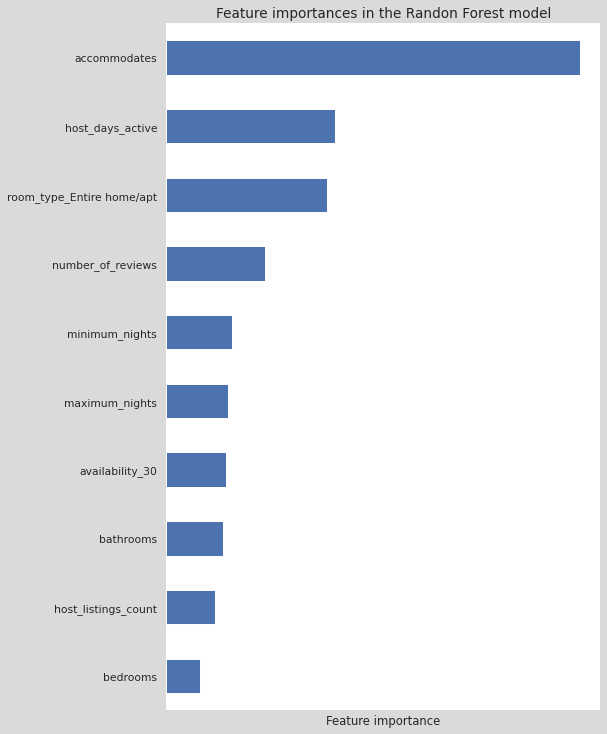

In [52]:
fig = plt.figure(figsize=(8, 13), facecolor= '#dadada', dpi=70)
# plotting first 40 important features
ft_weights_forest_reg['weight'].tail(10).plot(kind='barh')
plt.title("Feature importances in the Randon Forest model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.05)
plt.xticks([])
# Remove the splines 
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)